In [1]:
!pip3 install tensorflow==2.0.0-beta0

     |████████████████████████████████| 87.9MB 114kB/s 
     |████████████████████████████████| 501kB 48.9MB/s 
     |████████████████████████████████| 3.1MB 27.5MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [85]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print ("check tensorflow version: ", tf.__version__)

check tensorflow version:  2.0.0-beta0


#### Data-Set Preparation

We have already discussed about creating a window data-set where the previous _n_ values could be seen  as input and the current value at any timestep should be seen as output. You can always check the [Tensorflow Dataset documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). 


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series) # Creates a Dataset whose elements are slices of the given tensors.
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) #Combines (nests of) input elements into a dataset of (nests of) windows. 
  #A "window" is a finite dataset of flat elements of size size (or possibly fewer if there are not enough input elements to fill the window and drop_remainder evaluates to false).
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # Maps map_func across this dataset and flattens the result.
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # shuffle and split dataset into feature and label 
  dataset = dataset.batch(batch_size).prefetch(1) # create batches of data
  return dataset

##### Helper code block below to understand what exactly happened in the window_dataset function

In [23]:
a = tf.data.Dataset.range(14)
a = a.window(3, shift=2, drop_remainder=True)
a = a.flat_map(lambda x: x.batch(3))

for ele in a:
  print (ele.numpy())


a_ds = a.shuffle(2).map(lambda x: (x[:-1], x[-1]))

for ele_ds in a_ds:
  print (ele_ds)


a_ds = a_ds.batch(3).prefetch(1)  

for f in a_ds: 
  print (f) 

[0 1 2]
[2 3 4]
[4 5 6]
[6 7 8]
[ 8  9 10]
[10 11 12]
(<tf.Tensor: id=707, shape=(2,), dtype=int64, numpy=array([2, 3])>, <tf.Tensor: id=708, shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: id=711, shape=(2,), dtype=int64, numpy=array([0, 1])>, <tf.Tensor: id=712, shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: id=715, shape=(2,), dtype=int64, numpy=array([4, 5])>, <tf.Tensor: id=716, shape=(), dtype=int64, numpy=6>)
(<tf.Tensor: id=719, shape=(2,), dtype=int64, numpy=array([8, 9])>, <tf.Tensor: id=720, shape=(), dtype=int64, numpy=10>)
(<tf.Tensor: id=723, shape=(2,), dtype=int64, numpy=array([10, 11])>, <tf.Tensor: id=724, shape=(), dtype=int64, numpy=12>)
(<tf.Tensor: id=727, shape=(2,), dtype=int64, numpy=array([6, 7])>, <tf.Tensor: id=728, shape=(), dtype=int64, numpy=8>)
(<tf.Tensor: id=742, shape=(3, 2), dtype=int64, numpy=
array([[2, 3],
       [0, 1],
       [4, 5]])>, <tf.Tensor: id=743, shape=(3,), dtype=int64, numpy=array([4, 2, 6])>)
(<tf.Tensor: id=746, shape=(3, 2), dtype=in

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)  
baseline = 5
amplitude = 30
slope = 0.07
noise_level = 5




# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)



split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
### Create the Dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#### Define the Single Dense Layer 
Create the Single Dense layer network. Define the model in keras 

In [89]:
layer0 = tf.keras.layers.Dense(1, input_shape=[window_size]) # simple linear regression
model = tf.keras.models.Sequential([layer0])
model.summary() # 20 weights and 1 bias. 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=2e-6, momentum=0.95))
model.fit(dataset, epochs=80, verbose=2)

Epoch 1/80
31/31 - 0s - loss: 1389.2271
Epoch 2/80
31/31 - 0s - loss: 322.2040
Epoch 3/80
31/31 - 0s - loss: 113.2534
Epoch 4/80
31/31 - 0s - loss: 67.6966
Epoch 5/80
31/31 - 0s - loss: 55.4643
Epoch 6/80
31/31 - 0s - loss: 52.2479
Epoch 7/80
31/31 - 0s - loss: 50.0034
Epoch 8/80
31/31 - 0s - loss: 48.2674
Epoch 9/80
31/31 - 0s - loss: 46.9523
Epoch 10/80
31/31 - 0s - loss: 45.8275
Epoch 11/80
31/31 - 0s - loss: 44.8221
Epoch 12/80
31/31 - 0s - loss: 43.9633
Epoch 13/80
31/31 - 0s - loss: 43.2285
Epoch 14/80
31/31 - 0s - loss: 42.5896
Epoch 15/80
31/31 - 0s - loss: 42.0356
Epoch 16/80
31/31 - 0s - loss: 41.5572
Epoch 17/80
31/31 - 0s - loss: 41.1429
Epoch 18/80
31/31 - 0s - loss: 40.7839
Epoch 19/80
31/31 - 0s - loss: 40.4730
Epoch 20/80
31/31 - 0s - loss: 40.2037
Epoch 21/80
31/31 - 0s - loss: 39.9704
Epoch 22/80
31/31 - 0s - loss: 39.7683
Epoch 23/80
31/31 - 0s - loss: 39.5933
Epoch 24/80
31/31 - 0s - loss: 39.4417
Epoch 25/80
31/31 - 0s - loss: 39.3105
Epoch 26/80
31/31 - 0s - loss:

In [91]:
### Check the weights of the layers 

print ("layer weights: ", layer0.get_weights())

layer weights:  [array([[-0.05566975],
       [ 0.00197636],
       [ 0.03850545],
       [ 0.00670607],
       [ 0.02780796],
       [ 0.00251885],
       [-0.04190795],
       [ 0.01493306],
       [-0.01016574],
       [ 0.02917487],
       [-0.00881878],
       [ 0.03336044],
       [-0.05608542],
       [ 0.06337534],
       [ 0.03103708],
       [ 0.08481964],
       [ 0.01295905],
       [ 0.17536917],
       [ 0.26421386],
       [ 0.38030267]], dtype=float32), array([0.02621221], dtype=float32)]


##### This tells us that the 20 elements in first array are the weights and the bias parameter is represented by the 2nd array.  Since the input window size is 20 it makes sense to have 20 different weights.    

#### Prediction Time

In [82]:
print ("length of series : ", len(series))

length of series :  1461


In [92]:
## start taking first 20 elements of the series and then use the model to predict 
print (type(series))
print (series.shape)
print (series[5:10].shape)
print (series[5:10][np.newaxis].shape)
model.predict(series[1:21][np.newaxis])

<class 'numpy.ndarray'>
(1461,)
(5,)
(1, 5)


array([[34.312885]], dtype=float32)

In [0]:
### Generalize the previous block for every point in the time series
forecast = []
for t in range(len(series) - window_size):
  forecast.append(model.predict(series[t: t+window_size] [np.newaxis]))

# since we divided the data into training and test set depending upon the split time, so we will consider the forecast for the test data only
forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0] # check the first element of the array 

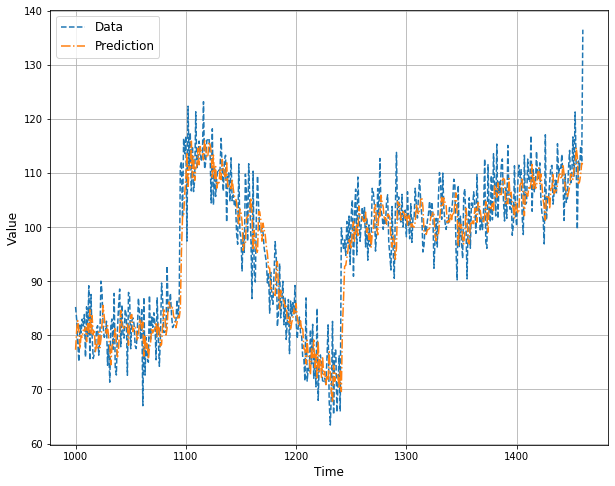

In [96]:
plt.figure(figsize=(10, 8))

plot_series(time_valid, x_valid, '--')
plot_series(time_valid, results, '-.')
labels = ['Data', 'Prediction']
plt.legend(labels, fontsize=12)
plt.show()

In [98]:
# Mean absolute error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7700324